In [1]:
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/sparg2.0")

import sparg_final as sparg
import tskit
import msprime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("always")

In [2]:
ts = tskit.load("two_pops.trees")

np.random.seed(1)
samples = list(np.random.choice(ts.samples(), 100, replace=False))
ts_sim, map_sim = ts.simplify(samples=samples, map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)

In [3]:
ts_small, maps_small = sparg.simplify_with_recombination(ts=ts_sim, flag_recomb=True)

location_x = []
composition = []

subpop_and_seq_len = {sample:{ subpop:0 for subpop in range(2)} for sample in ts_small.samples()}

for tree in ts_small.trees():
    for root in tree.roots:
        if ts_small.individual(ts_small.node(root).individual).location[0] < 50:
            subpop = 0
        else:
            subpop = 1
        for sample in tree.samples(root):
            subpop_and_seq_len[sample][subpop] += tree.span

for sample in subpop_and_seq_len:
    location_x.append(ts_small.individual(ts_small.node(sample).individual).location[0])
    composition.append(subpop_and_seq_len[sample][1] / sum(subpop_and_seq_len[sample].values()))

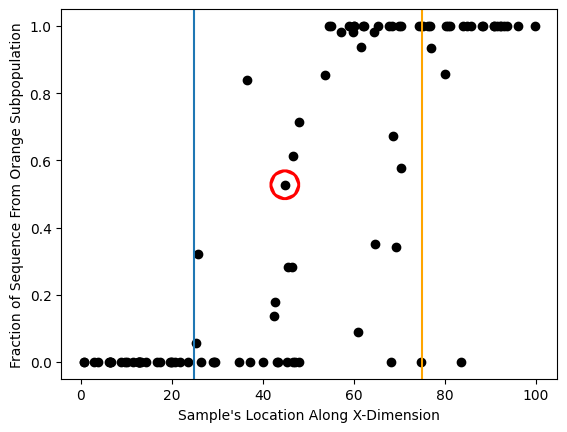

In [4]:
plt.scatter(location_x, composition, color="black")
plt.scatter(location_x[41], composition[41], color="none", edgecolors="red", linewidth=20, s=5)
plt.axvline(x = 25, label = "Starting Location of Blue Subpopulation")
plt.axvline(x = 75, color = "orange", label = "Starting Location of Orange Subpopulation")
plt.xlabel("Sample's Location Along X-Dimension")
plt.ylabel("Fraction of Sequence From Orange Subpopulation")
plt.savefig("two_pops_composition.svg")
plt.show()

In [5]:
output = sparg.estimate_spatial_parameters(ts=ts_small, verbose=True)

Prepared input parameters - Section Elapsed Time: 0.0027980804443359375 - Total Elapsed Time: 0.002804994583129883


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1886/1886 [00:01<00:00, 1394.38it/s]


Calculated covariance matrix - Section Elapsed Time: 1.3886957168579102 - Total Elapsed Time: 1.3918099403381348
Inverted covariance matrix - Section Elapsed Time: 0.09197115898132324 - Total Elapsed Time: 1.4839317798614502
Created root locations vector - Section Elapsed Time: 0.9043221473693848 - Total Elapsed Time: 2.388286828994751
Estimated dispersal rate - Section Elapsed Time: 0.0003399848937988281 - Total Elapsed Time: 2.3887557983398438


In [7]:
locations_df = sparg.create_true_locations_dataframe(ts=ts_sim, nodes=[41])
locations_df = pd.concat([locations_df, locations_df.apply(sparg.estimate_location, axis=1, ts=ts_small, spatial_parameters=output)], axis=1)

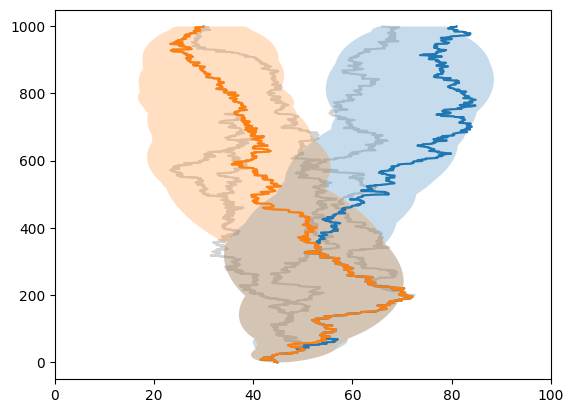

In [8]:
for i,region in locations_df.groupby(["sample", "interval_left"]):
    if i == (41, 0.0) or i == (41, 697443.0):
        left = []
        right = []
        # Fix this eventually
        for i,row in region.iterrows():
            left.append(row["estimated_location_0"]-1.96*math.sqrt(round(row["variance_in_estimated_location_0"],3)))
            right.append(row["estimated_location_0"]+1.96*math.sqrt(round(row["variance_in_estimated_location_0"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
for i,region in locations_df.groupby(["sample", "interval_left"]):
    plt.plot(region["true_location_0"], region["time"], color="lightgray", zorder=0)
    
for i,region in locations_df.groupby(["sample", "interval_left"]):
    if i == (41, 0.0) or i == (41, 697443.0):
        plt.plot(region["true_location_0"], region["time"])
plt.xlim(0,100)
plt.show()

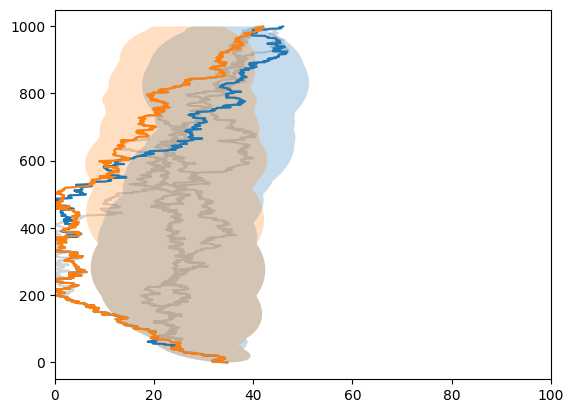

In [9]:
for i,region in locations_df.groupby(["sample", "interval_left"]):
    if i == (41, 0.0) or i == (41, 697443.0):
        left = []
        right = []
        # Fix this eventually
        for i,row in region.iterrows():
            left.append(row["estimated_location_1"]-1.96*math.sqrt(round(row["variance_in_estimated_location_1"],3)))
            right.append(row["estimated_location_1"]+1.96*math.sqrt(round(row["variance_in_estimated_location_1"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
for i,region in locations_df.groupby(["sample", "interval_left"]):
    plt.plot(region["true_location_1"], region["time"], color="lightgray", zorder=0)
    
for i,region in locations_df.groupby(["sample", "interval_left"]):
    if i == (41, 0.0) or i == (41, 697443.0):
        plt.plot(region["true_location_1"], region["time"])
plt.xlim(0,100)
plt.show()

# OLD

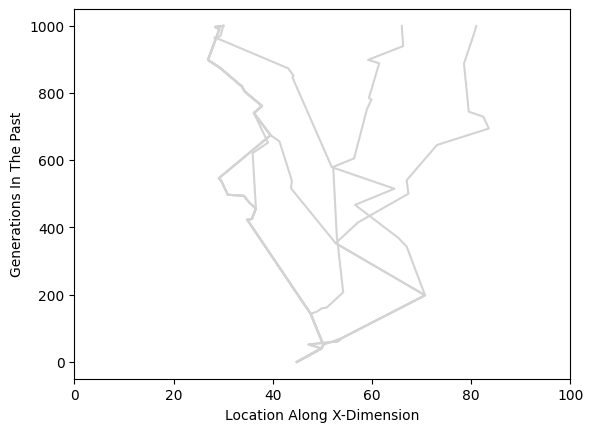

In [396]:
locations_of_nodes = output[6]
variances_in_node_locations = output[7]

paths_41 = sparg.get_paths_for_node(ts=ts_small, node=41)

for i,path in enumerate(paths_41):
    times = []
    true_locations = []
    estimated_locations = []
    estimated_left = []
    estimated_right = []
    for node in path:
        times.append(ts_small.node(node).time)
        true_locations.append(ts_small.individual(ts_small.node(node).individual).location[0])
        estimated_locations.append(locations_of_nodes[node][0])
        estimated_left.append(locations_of_nodes[node][0]-(1.96*math.sqrt(round(variances_in_node_locations[node][0][0]))))
        estimated_right.append(locations_of_nodes[node][0]+(1.96*math.sqrt(round(variances_in_node_locations[node][0][0]))))
    plt.plot(true_locations, times, color="lightgray", zorder=0)
plt.xlim(0, 100)
plt.xlabel("Location Along X-Dimension")
plt.ylabel("Generations In The Past")
plt.savefig("two_pops_genetic_ancestors.svg")
plt.show()

In [5]:
import pandas

def create_true_locations_dataframe(ts, nodes, dim=2):
    sample = []
    interval_left = []
    interval_right = []
    time = []
    location = []
    for node in nodes:
        just_node, map = ts.simplify(samples=[node], map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)
        for tree in just_node.trees():
            path = [0] + list(sparg.ancestors(tree, 0))
            for i,n in enumerate(path):
                path[i] = np.argwhere(map==n)[0][0]
            for i,n in enumerate(path):
                sample.append(node)
                interval_left.append(tree.interval.left)
                interval_right.append(tree.interval.right)
                time.append(ts.node(n).time)
                indiv = ts.node(n).individual
                if indiv != -1:
                    location.append(ts.individual(indiv).location[:dim])
                else:
                    location.append(None)
    df = pandas.DataFrame({
        "sample":sample,
        "interval_left":interval_left,
        "interval_right":interval_right,
        "time":time,
    })
    locs = pandas.DataFrame(location, columns=["true_location_"+str(d) for d in range(dim)])
    df = pandas.concat([df, locs], axis=1)
    return df

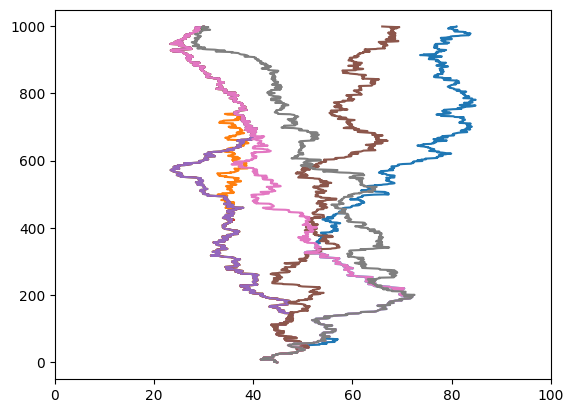

In [399]:
for i,region in locations_df.groupby(["sample", "interval_left"]):
    plt.plot(region["true_location"], region["time"])
plt.xlim(0,100)
plt.show()

In [10]:
def locate_ancestor(sample, chrom_pos, time, ts, spatial_parameters):
    sigma = spatial_parameters[0]
    paths = spatial_parameters[2]
    inverted_cov_mat = spatial_parameters[3]
    sample_locs_to_root_locs = spatial_parameters[6]
    root_locations = spatial_parameters[7]
    node_shared_times = spatial_parameters[8]
    node_paths = spatial_parameters[9]
    tree = ts.at(chrom_pos)
    path = [sample] + list(sparg.ancestors(tree, sample))
    for i,node in enumerate(path):
        if ts.node(node).time >= time:
            above = node
            if i > 0:
                below = path[i-1]
            else:
                below = -1
            break
    ancestor_specific_sharing = node_shared_times[above].copy()
    root_location = root_locations[node_paths[above][-1]]
    additional_time = ts.node(above).time - time
    for i,path in enumerate(paths):
        if below in path:
            ancestor_specific_sharing[i] += additional_time
    matmul_prod = np.matmul(ancestor_specific_sharing, inverted_cov_mat)
    ancestor_location = root_location + np.matmul(matmul_prod, sample_locs_to_root_locs)
    explained_variance = np.matmul(matmul_prod, np.transpose(ancestor_specific_sharing))
    ones = np.ones(inverted_cov_mat.shape[0])
    unexplained_denominator = np.matmul(np.matmul(np.transpose(ones),inverted_cov_mat),ones)
    unexplained_numerator = (1-np.matmul(np.matmul(np.transpose(ancestor_specific_sharing),inverted_cov_mat),ones))**2
    corrected_variance_scaling_factor = (ts.max_root_time-time)-explained_variance+(unexplained_numerator/unexplained_denominator)
    variance_in_ancestor_location = sigma*corrected_variance_scaling_factor
    return ancestor_location, variance_in_ancestor_location

def estimate_location(row, ts, spatial_parameters):
    location, variance = locate_ancestor(sample=int(row["sample"]), chrom_pos=row["interval_left"], time=row["time"], ts=ts, spatial_parameters=spatial_parameters)
    output = []
    indices = []
    for i,loc in enumerate(location):
        output.append(loc)
        indices.append("estimated_location_"+str(i))
        output.append(variance[i][i])
        indices.append("variance_in_estimated_location_"+str(i))
    return pandas.Series(output, index=indices)


In [554]:
locations_df

,sample,interval_left,interval_right,time,true_location_0,true_location_1,estimated_location_0,variance_in_estimated_location_0,estimated_location_1,variance_in_estimated_location_1
0,41,0.0,404885.0,0.0,44.855000,34.732062,44.855000,1.668046e-10,34.732062,1.656365e-10
1,41,0.0,404885.0,1.0,44.741530,34.586386,44.948435,8.914887e-01,34.612148,8.852457e-01
2,41,0.0,404885.0,2.0,44.196093,31.844716,45.041870,1.759022e+00,34.492235,1.746704e+00
3,41,0.0,404885.0,3.0,44.539157,31.895104,45.135304,2.602601e+00,34.372321,2.584375e+00
4,41,0.0,404885.0,4.0,44.539130,32.130651,45.228739,3.422225e+00,34.252408,3.398259e+00
...,...,...,...,...,...,...,...,...,...,...
995,41,0.0,404885.0,995.0,79.753963,45.603904,72.167209,1.511550e+01,34.567328,1.500965e+01
996,41,0.0,404885.0,996.0,79.708494,45.368133,72.167209,1.445955e+01,34.567328,1.435829e+01
997,41,0.0,404885.0,997.0,79.741712,45.285712,72.167209,1.374169e+01,34.567328,1.364546e+01
998,41,0.0,404885.0,998.0,80.973606,45.913329,72.167209,1.296194e+01,34.567328,1.287116e+01


In [431]:
def ts_bubble( start=0.01, x = 0.25, t=1 ):     
    ts_bubble = tskit.TableCollection(sequence_length=1e3)
    node_table = ts_bubble.nodes
    node_table.set_columns(
        flags = np.array([1, 1, 131072, 131072, 0, 0], dtype=np.uint32),
        time = np.array([ 0.0, 0.0, start*t, start*t, (start+x)*t, t ]),
        individual = np.array(list(range(2)) + [-1,-1,-1,-1], dtype = np.int32)
    )
    
    individual_table = ts_bubble.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0], dtype = np.uint32),
        location = np.array([-0.5,0.5]),
        location_offset = np.array([0,1,2], dtype = np.uint64) 
    )
    
    edge_table = ts_bubble.edges
    edge_table.set_columns(
        left=np.array([0.0, 5e2, 0.0, 0.0, 5e2, 0.0]),
        right=np.array([5e2, 1e3, 1e3, 5e2, 1e3, 1e3]),
        parent=np.array([2, 3, 5, 4, 4, 5], dtype=np.int32),  # References IDs in the node table
        child=np.array([0, 0, 1, 2, 3, 4], dtype=np.int32),  # References IDs in the node table
    )
    ts_bubble.sort()
    return ts_bubble.tree_sequence()


def ts_singlecompound(x=0.25, y=0.125, t=1 ):     
    ts_singlecompound = tskit.TableCollection(sequence_length=1e3)
    node_table = ts_singlecompound.nodes
    node_table.set_columns(
        flags = np.array([1, 1, 131072, 131072, 0, 0], dtype=np.uint32),
        time = np.array([ 0.0, 0.0, (1-x)*t, (1-x)*t, (1-y)*t, t ]),
        individual = np.array(list(range(2)) + [-1,-1,-1,-1], dtype = np.int32)
    )
    
    individual_table = ts_singlecompound.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0], dtype = np.uint32),
        location = np.array([-0.5,0.5]),
        location_offset = np.array([0,1,2], dtype = np.uint64) 
    )
    
    edge_table = ts_singlecompound.edges
    edge_table.set_columns(
        left=np.array([0.0, 5e2, 0.0, 0.0, 5e2, 5e2]),
        right=np.array([5e2, 1e3, 1e3, 5e2, 1e3, 1e3]),
        parent=np.array([2, 3, 4, 4, 5, 5], dtype=np.int32),  # References IDs in the node table
        child=np.array([0, 0, 1, 2, 3, 4], dtype=np.int32),  # References IDs in the node table
    )
    ts_singlecompound.sort()
    return ts_singlecompound.tree_sequence()

def ts_doublecompound(x=0.75, y=0.5, z = 0.4, w = 0.2, t=1): 
    ts_doublecompound = tskit.TableCollection(sequence_length=1e3)
    node_table = ts_doublecompound.nodes
    node_table.set_columns(
        # flags = np.array([1, 1, 131072, 131072,0, 131072, 131072, 0 ,0], dtype=np.uint32),
        flags = np.array([1, 1, 0, 0,0, 0, 0, 0 ,0], dtype=np.uint32),
        time = np.array([ 0.0, 0.0, (1-x)*t, (1-x)*t, (1-y)*t, (1-z)*t, (1-z)*t, (1-w)*t, t ]),
        individual = np.array(list(range(2)) + [-1 for i in range(7)], dtype = np.int32)
    )
    
    individual_table = ts_doublecompound.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0], dtype = np.uint32),
        location = np.array([-0.5,0.5]),
        location_offset = np.array([0,1,2], dtype = np.uint64) 
    )
    
    edge_table = ts_doublecompound.edges
    edge_table.set_columns(
        right=np.array([3e2, 1e3, 1e3, 3e2, 6e2, 1e3, 1e3, 6e2, 1e3, 6e2]),
        left=np.array([0.0, 3e2, 0.0, 0.0, 3e2, 6e2, 3e2, 3e2, 6e2, 3e2]),
        parent=np.array([2, 3, 4, 4, 5, 6, 7, 8, 7, 8], dtype=np.int32),  # References IDs in the node table
        child=np.array([0, 0, 1, 2, 3, 3, 4, 5, 6, 7], dtype=np.int32),  # References IDs in the node table
    )
    ts_doublecompound.sort()
    return ts_doublecompound.tree_sequence()

def ts_singlecompound_3sam(x=0.25, y=0.125, z=0.25, t=1 ):     
    ts_singlecompound_3sam = tskit.TableCollection(sequence_length=1e3)
    node_table = ts_singlecompound_3sam.nodes
    node_table.set_columns(
        flags = np.array([1, 1, 1, 0, 131072, 131072, 0, 0], dtype=np.uint32),
        time = np.array([ 0.0, 0.0, 0.0, z*t ,(1-x)*t, (1-x)*t, (1-y)*t, t ]),
        individual = np.array(list(range(3)) + [-1,-1,-1,-1,-1], dtype = np.int32)
    )
    
    individual_table = ts_singlecompound_3sam.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0,0], dtype = np.uint32),
        location = np.array([-20,-30,50]),
        location_offset = np.array([0,1,2,3], dtype = np.uint64) 
    )
    
    edge_table = ts_singlecompound_3sam.edges
    edge_table.set_columns(
        left=np.array([0.0, 0.0, 5e2, 0.0, 0.0, 5e2, 0, 5e2]),
        right=np.array([1e3, 1e3, 1e3, 5e2, 1e3, 1e3, 5e2, 1e3]),
        parent=np.array([3, 3, 4, 5, 6, 7, 6, 7], dtype=np.int32),  # References IDs in the node table
        child=np.array([0, 1, 3, 3, 2, 4, 5, 6], dtype=np.int32),  # References IDs in the node table
    )
    ts_singlecompound_3sam.sort()
    return ts_singlecompound_3sam.tree_sequence()

def ts_stacked(x=0.25, n=1, seq_len = 1000 ):     
    ts_stacked = tskit.TableCollection(sequence_length=1e3)
    n_nodes = 3 + n*3
    # n_steps = 3 + 2*n 
    
    node_table = ts_stacked.nodes
    flag_list = np.zeros((n_nodes,))
    flag_list[0] = 1
    flag_list[1] = 1
    time_list = np.zeros((n_nodes,))
    time_list[-1] = (3 +2*n )*x
    
    for i in range(n):
        flag_list[2 +3*i] = 131072
        flag_list[2 +3*i + 1] = 131072
        time_list[2 +3*i] = (3 + 2*i)*x
        time_list[2 +3*i + 1] = (3 + 2*i)*x
        time_list[2 +3*i + 2] = (3 + 2*i + 1)*x
    
    node_table.set_columns(
        flags = np.array(flag_list, dtype=np.uint32),
        time = np.array(time_list),
        individual = np.array(list(range(2)) + [-1 for i in range(n_nodes-2)], dtype = np.int32)
    )
    
    individual_table = ts_stacked.individuals 
    individual_table.set_columns( 
        flags = np.array([0,0], dtype = np.uint32),
        location = np.array([-0.5,0.5]),
        location_offset = np.array([0,1,2], dtype = np.uint64) 
    )
    
    edge_table = ts_stacked.edges
    
    seqlen = seq_len/float(n+1)
    child = [0,0,1]
    parent = [2,3,4]
    left = [ seqlen, 0, 0  ]
    right = [ (n+1)*seqlen, seqlen, (n+1)*seqlen ] 
    for i in range(n-1): 
        child += [ 2 + 3*i, 2+3*i, 2+3*i+1, 2+3*i+2 ]
        parent += [ 2 + 3*(i+1), 2+3*(i+1)+1, 2+3*i+2, 2+3*(i+1)+2 ]
        left += [(i+2)*seqlen , (i+1)*seqlen , i*seqlen , (i+1)*seqlen ]
        right += [(n+1)*seqlen , (i+2)*seqlen , (i+1)*seqlen  , (n+1)*seqlen ]
    child += [2+3*(n-1), 3*n, 3*n+1  ]
    parent += [2+3*n, 3*n+1, 3*n+2 ]
    left += [n*seqlen, (n-1)*seqlen, n*seqlen ]
    right += [(n+1)*seqlen, n*seqlen, (n+1)*seqlen]
    
    # print(child)
    # print(parent)
    # print(left)
    # print(right)
    
    edge_table.set_columns(
        left=np.array(left),
        right=np.array(right),
        parent=np.array(parent, dtype=np.int32),  # References IDs in the node table
        child=np.array(child, dtype=np.int32),  # References IDs in the node table
    )
    ts_stacked.sort()
    return ts_stacked.tree_sequence()

In [464]:
ts_toy = ts_bubble()
toy_df = create_true_locations_dataframe(ts=ts_toy, nodes=ts_toy.samples())
output_toy = sparg.estimate_spatial_parameters(ts=ts_toy, return_node_positions=True)
toy_df = pandas.concat([toy_df, toy_df.apply(estimate_location, axis=1, ts=ts_toy, spatial_parameters=output_toy)], axis=1)


In [474]:
toy_df.dtypes

sample                              int32
interval_left                     float64
interval_right                    float64
time                              float64
true_location                     float64
estimated_location                float64
variance_in_estimated_location    float64
dtype: object

[0.0, 40.0, 52.0, 61.0, 71.0, 198.0, 343.0, 369.0, 467.0, 515.0, 579.0, 846.0, 851.0, 873.0, 961.0, 964.0, 967.0, 970.0, 999.0]
[-0.49999999999999956, -0.6020202879376788, -0.7840516816418648, -0.7235205543103663]
[-0.49999999999999956, -0.3873130453956537, -0.0719483183581347, 0.6568538876436999]
[0.0, 40.0, 52.0, 61.0, 71.0, 198.0, 343.0, 369.0, 467.0, 515.0, 579.0, 846.0, 851.0, 873.0, 961.0, 964.0, 967.0, 970.0, 999.0]
[-0.49999999999999956, -0.6020202879376788, -0.7840516816418648, -0.7235205543103663]
[-0.49999999999999956, -0.38731304539565375, -0.0719483183581347, 0.6568538876436999]
[0.0, 40.0, 52.0, 61.0, 71.0, 198.0, 343.0, 369.0, 467.0, 515.0, 579.0, 846.0, 851.0, 873.0, 961.0, 964.0, 967.0, 970.0, 999.0]
[0.5, -0.7235205543103663]
[0.5, 0.6568538876436999]


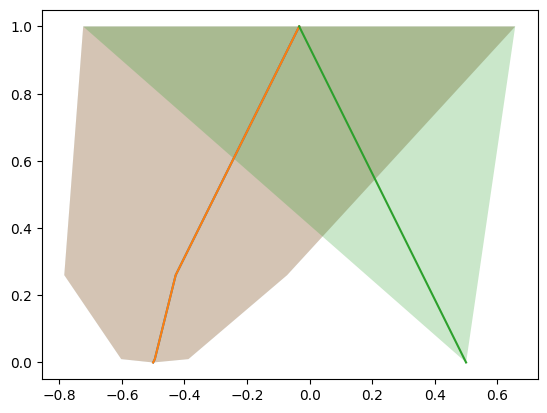

In [480]:
for i,region in toy_df.groupby(["sample", "interval_left"]):
    left = []
    right = []
    # Fix this eventually
    for i,row in region.iterrows():
        left.append(row["estimated_location"]-1.96*math.sqrt(row["variance_in_estimated_location"]))
        right.append(row["estimated_location"]+1.96*math.sqrt(row["variance_in_estimated_location"]))
    plt.fill_betweenx(
        y=region["time"],
        x1=left,
        x2=right,
        alpha=0.25,
        label="estimated"
    )
for i,region in toy_df.groupby(["sample", "interval_left"]):
    plt.plot(region["estimated_location"], region["time"])
plt.show()